In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import msprime
import numpy as np
import pandas as pd
import iBioGen

from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, StandardScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def simulate(Ne=1e4, epsilon=1/3, nsamps=5, num_replicates=20, sequence_length=1e5,
             span_normalise=False, polarised=True):
    # Number of independent simulations to perform
    # num_replicates = 20
    #
    # Population size at time 0
    # Ne = 1e4
    #
    # Instantaneous size change term
    # epsilon > 0 = Bottleneck
    # epsilon < 0 = Expansion
    # epsilon = 1/3
    #
    # Number of contemporary samples to simulate
    # nsamps = 5

    constant_sfs = []
    expanding_sfs = []
    
    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=Ne)

    # Simulate constant size
    ts = msprime.sim_ancestry({"A": nsamps},
                              demography=demography,
                              sequence_length=sequence_length,
                              recombination_rate=1e-9,
                              num_replicates=num_replicates,
                              )

    # Accumulate SFS for constant simulations
    for t in ts:
        mutated_ts = msprime.sim_mutations(t, rate=1e-8)
        constant_sfs.append(mutated_ts.allele_frequency_spectrum(mode="site", span_normalise=span_normalise, polarised=polarised))

    # Modify the demography to add a population size change 300 generations in the past
    demography.add_population_parameters_change(time=300, initial_size=Ne*epsilon)

    ts = msprime.sim_ancestry({"A": nsamps},
                              demography=demography,
                              sequence_length=sequence_length,
                              recombination_rate=1e-9,
                              num_replicates=num_replicates,
                              )

    for t in ts:
        mutated_ts = msprime.sim_mutations(t, rate=1e-8)
        expanding_sfs.append(mutated_ts.allele_frequency_spectrum(mode="site", span_normalise=span_normalise, polarised=polarised))

    # Drop the monomorphic bins which are all zeros anyway - .iloc[:, 1:-1]
    constant_sfs = pd.DataFrame(constant_sfs).iloc[:, 1:-1]
    constant_sfs.index = ['constant'] * num_replicates
    expanding_sfs = pd.DataFrame(expanding_sfs).iloc[:, 1:-1]
    expanding_sfs.index = ['expanding'] * num_replicates

    sims = pd.concat([constant_sfs, expanding_sfs])
    return sims

In [3]:
def plot_simulations_pca(sims, ax='',
                            figsize=(8, 8),
                            normalise=True,
                            transform=True,
                            outfile='',
                            colorbar=False,
                            verbose=False):
    """
    Plot summary statistics for simulations projected into PC space.

    :param str sims: 
    :param matplotlib.pyplot.axis ax:
    :param tuple figsize:

    :param int/float select: 
    :param int/float tol:
    :param str title:
    :param str outfile:
    :param bool verbose:

    :return: Return the `matplotlib.pyplot.axis` on which the simulations are
        plotted.
    """
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)

    if normalise:
        # Normalise over rows
        # Any rows with no snps will result in na
        sim_df = sims.div(sims.sum(axis=1), axis=0).fillna(0)
    else:
        sim_df = sims

    if transform:
        #sim_df = StandardScaler().fit_transform(sim_df)
        sim_df = PowerTransformer(method='yeo-johnson').fit_transform(sim_df)
    
    pca = PCA(n_components=2)
    dat = pca.fit_transform(sim_df)


    colors= ['coral' if l == "constant" else 'dodgerblue' for l in sims.index]
    sc = ax.scatter(dat[:, 0], dat[:, 1], label=sims.index, c=colors, alpha=0.75)

    if colorbar:
        plt.colorbar(sc)

    ## Remove a bunch of visual noise
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(top='off', bottom='off', left='off', right='off')

    # Don't care so much about variance explained for these simulations
    #var_expl = pca.explained_variance_ratio_
    #ax.set_xlabel("Variance explained {:.3}%".format(var_expl[0]*100), fontsize=15)
    #ax.set_ylabel("Variance explained {:.3}%".format(var_expl[1]*100), fontsize=15)

    if outfile:
        try:
            plt.savefig(outfile)
            if verbose: print("Wrote figure to: {}".format(outfile))
        except Exception as inst:
            raise Exception("Failed saving figure: {}".format(inst))
        plt.close()

    return ax

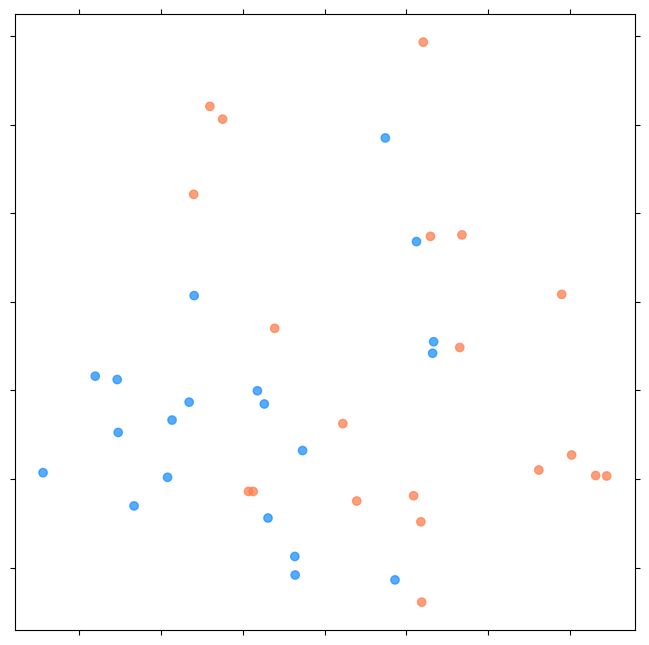

In [7]:
sims = simulate(epsilon=0.5, nsamps=10)
ax = plot_simulations_pca(sims, normalise=False)


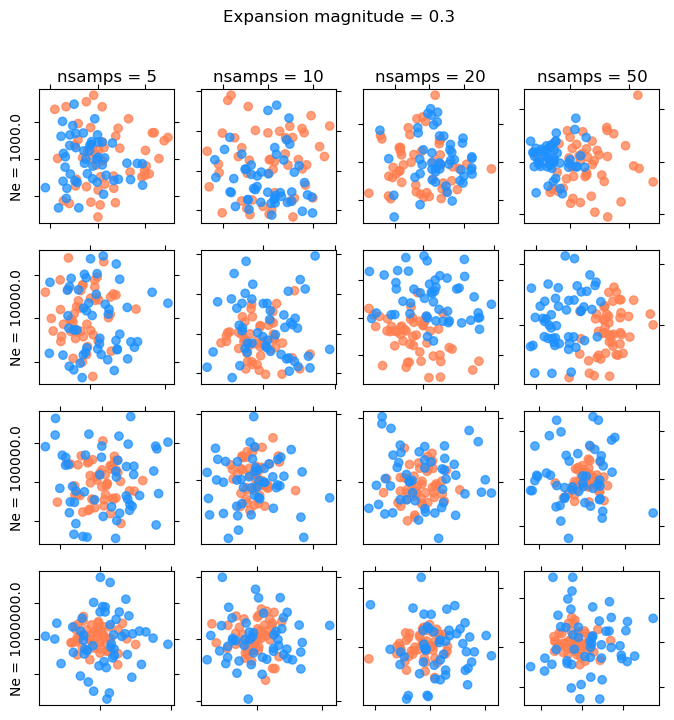

In [12]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = [x for xs in axs for x in xs]
Nes = [1e3, 1e4, 1e5, 1e6]
nsamps = [5, 10, 20, 50]
sequence_length=1e5
epsilon = .3
nsims = 50
idx = 0
for Ne in Nes:
    for nsamp in nsamps:
        sims = simulate(num_replicates=nsims, Ne=Ne, nsamps=nsamp, epsilon=epsilon, sequence_length=sequence_length)
        ax = plot_simulations_pca(ax=axs[idx], sims=sims, normalise=True, transform=True)
        if idx % 4 == 0:
            ax.set_ylabel(f"Ne = {Ne}")
        if idx < 4:
            ax.set_title(f"nsamps = {nsamp}")
        idx += 1
_ = plt.suptitle(f"Expansion magnitude = {epsilon}")

In [327]:
sims = simulate(Ne=1e4, epsilon=0.3, nsamps=10, num_replicates=5)
#ax = plot_simulations_pca(sims)
#(sims/sims.sum())
sims
#sims.div(sims.sum(axis=1), axis=0)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
constant,52.0,25.0,5.0,15.0,8.0,6.0,1.0,2.0,0.0,7.0,1.0,0.0,0.0,2.0,4.0,2.0,0.0,0.0,0.0
constant,42.0,14.0,10.0,4.0,1.0,1.0,2.0,9.0,8.0,12.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
constant,42.0,19.0,24.0,1.0,16.0,0.0,0.0,0.0,12.0,0.0,11.0,0.0,0.0,0.0,17.0,0.0,19.0,0.0,0.0
constant,32.0,10.0,21.0,16.0,11.0,39.0,2.0,0.0,11.0,2.0,14.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
constant,27.0,41.0,11.0,2.0,3.0,2.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,6.0,1.0
expanding,31.0,5.0,4.0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,3.0,0.0,11.0,0.0,1.0
expanding,17.0,10.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
expanding,12.0,12.0,3.0,7.0,2.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0
expanding,13.0,5.0,2.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
expanding,23.0,14.0,3.0,6.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,4.0,3.0,4.0,0.0


In [222]:
Ne = 1e4
demography = msprime.Demography()
demography.add_population(name="A", initial_size=Ne)
demography.add_population_parameters_change(time=300, initial_size=Ne*0.1)
demography.debug()


,start,end,growth_rate
A,10000.0,10000.0,0
time,type,parameters,effect
300,Population parameter change,"population=-1, initial_size=1000.0",initial_size → 1e+03 for all populations
,start,end,growth_rate
A,1000.0,1000.0,0


## Stairwayplot analysis
`java -cp stairway_plot_es Stairbuilder bp.blueprint`
`bash bp.blueprint.sh`

In [60]:
blueprint_template = """
#example blueprint file
#input setting
popid: {popid} # id of the population (no white space)
nseq: {nseqs} # number of sequences
L: {sequence_length} # total number of observed nucleic sites, including polymorphic and monomorphic
whether_folded: false # whethr the SFS is folded (true or false)
SFS: {sfs}
#smallest_size_of_SFS_bin_used_for_estimation: 1 # default is 1; to ignore singletons, uncomment this line and change this number to 2
#largest_size_of_SFS_bin_used_for_estimation: 29 # default is n-1; to ignore singletons, uncomment this line and change this number to nseq-2
pct_training: 0.67 # percentage of sites for training
nrand: {breakpoints} # number of random break points for each try (separated by white space)
project_dir: {popid} # project directory
stairway_plot_dir: stairway_plot_es # directory to the stairway plot files
ninput: 200 # number of input files to be created for each estimation
#random_seed: 6
#output setting
mu: 1e-8 # assumed mutation rate per site per generation
year_per_generation: 1 # assumed generation time (in years)
#plot setting
plot_title: {popid} # title of the plot
xrange: 0.1,10000 # Time (1k year) range; format: xmin,xmax; "0,0" for default
yrange: 0,0 # Ne (1k individual) range; format: xmin,xmax; "0,0" for default
xspacing: 2 # X axis spacing
yspacing: 2 # Y axis spacing
fontsize: 12 # Font size
"""
popid_template = "{Ne}-{nsamps}-{epsilon}-{sequence_length}"

In [ ]:
## Here we run one simulation for constant and one for expanding given a set of parameters
## then populate the stairwayplot blueprint file with the correct information and write them to files
##
## Prep the blueprint files like this:
## `for i in `ls *.blueprint`; do echo $i; java -cp stairway_plot_es Stairbuilder $i; done`
## Then run them: `bash *.sh`

In [77]:
sequence_length = 1e6
nsamps = 50
Ne = 1e5
epsilon = 1/3
res = simulate(Ne=Ne, epsilon=epsilon, nsamps=nsamps, num_replicates=1, sequence_length=sequence_length)
popid_template = "{Ne}-{nsamps}-{epsilon}-{sequence_length}".format(Ne=Ne, nsamps=nsamps,
                                                                    epsilon=epsilon, sequence_length=sequence_length)
display(res)

for model in ["constant", "expanding"]:
    popid = f"{model}-"+popid_template.format(Ne=Ne, nsamps=nsamps, epsilon=epsilon, sequence_length=sequence_length)
    sfs = " ".join(res.loc[model].astype(str).values)
    nseqs = nsamps*2
    breakpoints = " ".join([str(int(np.ceil(x))) for x in [(nseqs-2)/4, (nseqs-2)/2, (nseqs-2)*3/4, (nseqs-2)]])
    print(model, sfs, breakpoints)
    my_blueprint = blueprint_template.format(popid=popid, nseqs=nsamps*2, sequence_length=sequence_length,
                                             sfs=sfs, breakpoints=breakpoints)
    with open(f"./swp/{popid}.blueprint", 'w') as outfile:
        outfile.write(my_blueprint)

,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
constant,4093.0,1863.0,984.0,1052.0,839.0,759.0,525.0,498.0,406.0,366.0,...,19.0,22.0,41.0,19.0,45.0,105.0,31.0,9.0,21.0,9.0
expanding,1415.0,679.0,404.0,333.0,238.0,127.0,235.0,124.0,98.0,78.0,...,0.0,8.0,7.0,23.0,2.0,10.0,10.0,3.0,4.0,12.0


constant 4093.0 1863.0 984.0 1052.0 839.0 759.0 525.0 498.0 406.0 366.0 475.0 357.0 418.0 365.0 324.0 288.0 255.0 213.0 259.0 242.0 215.0 131.0 134.0 126.0 103.0 192.0 137.0 221.0 140.0 95.0 89.0 130.0 100.0 155.0 121.0 138.0 105.0 147.0 123.0 105.0 71.0 82.0 141.0 80.0 97.0 95.0 113.0 77.0 115.0 73.0 127.0 78.0 99.0 126.0 93.0 52.0 107.0 36.0 72.0 62.0 69.0 74.0 81.0 31.0 95.0 66.0 17.0 54.0 21.0 20.0 69.0 74.0 54.0 66.0 23.0 23.0 27.0 28.0 68.0 51.0 74.0 23.0 20.0 70.0 73.0 88.0 25.0 31.0 65.0 19.0 22.0 41.0 19.0 45.0 105.0 31.0 9.0 21.0 9.0 25 49 74 98
expanding 1415.0 679.0 404.0 333.0 238.0 127.0 235.0 124.0 98.0 78.0 108.0 91.0 64.0 77.0 71.0 107.0 66.0 46.0 46.0 54.0 51.0 95.0 81.0 82.0 48.0 48.0 67.0 59.0 84.0 39.0 6.0 67.0 16.0 38.0 40.0 7.0 60.0 20.0 22.0 32.0 21.0 45.0 27.0 22.0 30.0 18.0 21.0 33.0 24.0 32.0 35.0 26.0 11.0 14.0 11.0 20.0 19.0 20.0 11.0 12.0 2.0 2.0 14.0 9.0 25.0 4.0 9.0 29.0 1.0 14.0 12.0 23.0 19.0 9.0 20.0 50.0 10.0 51.0 6.0 0.0 0.0 0.0 0.0 26.0 14.0 13.0 6

In [61]:
for model in ["constant", "expanding"]:
    popid = f"{model}-"+popid_template.format(Ne=Ne, nsamps=nsamps, epsilon=epsilon, sequence_length=sequence_length)
    sfs = " ".join(res.loc[model].astype(str).values)
    nseqs = nsamps*2
    breakpoints = " ".join([str(int(np.ceil(x))) for x in [(nseqs-2)/4, (nseqs-2)/2, (nseqs-2)*3/4, (nseqs-2)]])
    print(sfs, breakpoints)
    my_blueprint = blueprint_template.format(popid=popid, nseqs=nsamps*2, sequence_length=sequence_length,
                                             sfs=sfs, breakpoints=breakpoints)
    print(my_blueprint)
    with open(f"./swp/{popid}.blueprint", 'w') as outfile:
        outfile.write(my_blueprint)

3533.0 1711.0 1438.0 821.0 1036.0 558.0 646.0 380.0 417.0 2 4 6 8

#example blueprint file
#input setting
popid: constant-100000.0-5-0.1-1000000.0 # id of the population (no white space)
nseq: 10 # number of sequences
L: 1000000.0 # total number of observed nucleic sites, including polymorphic and monomorphic
whether_folded: false # whethr the SFS is folded (true or false)
SFS: 3533.0 1711.0 1438.0 821.0 1036.0 558.0 646.0 380.0 417.0
#smallest_size_of_SFS_bin_used_for_estimation: 1 # default is 1; to ignore singletons, uncomment this line and change this number to 2
#largest_size_of_SFS_bin_used_for_estimation: 29 # default is n-1; to ignore singletons, uncomment this line and change this number to nseq-2
pct_training: 0.67 # percentage of sites for training
nrand: 2 4 6 8 # number of random break points for each try (separated by white space)
project_dir: constant-100000.0-5-0.1-1000000.0 # project directory
stairway_plot_dir: stairway_plot_es # directory to the stairway plot files
n